# Lab 06 - Uncertainty Quantification

## Tasks

- Train different machine learning algorithms on noisy data
- Predict the uncertainty from the trained model

## Set up environment

In [1]:
%reset -f
!pip install botorch
!pip install cheetah-accelerator
!pip install blitz-bayesian-pytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm # For progress bar

# Gaussian process
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize


# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim

## Create training data

We start by generating noisy data from a model of beam propagating through a single quad magnet (characterized by a magnetic strength `K1`). In order to simulate fluctuations in beam parameters and noise in the beam size measurement, we add noise in the model.

In [3]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
    beta_x=torch.tensor(5.0),
    alpha_x=torch.tensor(0.0),
    emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
    [
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q1",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0))
    ]
)

def calculate_x_beamsize(K, add_noise=False):
    # set beamline parameters
    beamline.Q1.k1 = K

    # track the beam
    final_beam = beamline.track(incoming_beam)

    # noise
    if add_noise:
        noise = torch.randn_like(K) * 1e-1
    else:
        noise = 0.0

    # return the beam size in x (in mm)
    return final_beam.sigma_x * 1e3 + noise

In [4]:
# Generate 400 samples for K1 varying between -300 and 300
n_samples = 400
bounds = torch.tensor([-30.0, 30.0])
train_x = torch.rand(n_samples) * (bounds[1] - bounds[0]) + bounds[0]
train_x = train_x.reshape(-1,1)
train_y = torch.cat([calculate_x_beamsize(train_x, add_noise=True)]).detach()

Text(0, 0.5, 'Beam size')

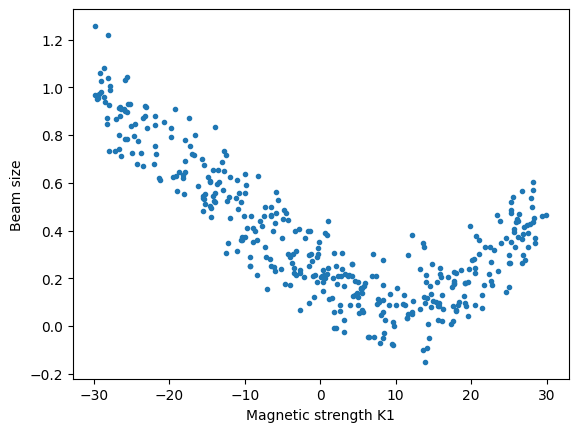

In [5]:
plt.plot(train_x, train_y, '.' )
plt.xlabel('Magnetic strength K1')
plt.ylabel('Beam size')

# Gaussian process

Here we fit a Gaussian process to the data, we draw a few samples from the GP and plot them, along with the uncertainty.

In [6]:
# Define a Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood
gp = SingleTaskGP(
    train_x.double(), train_y.double(),
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)

# Train model hyperparameters by minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Text(0, 0.5, 'Normalized beam size')

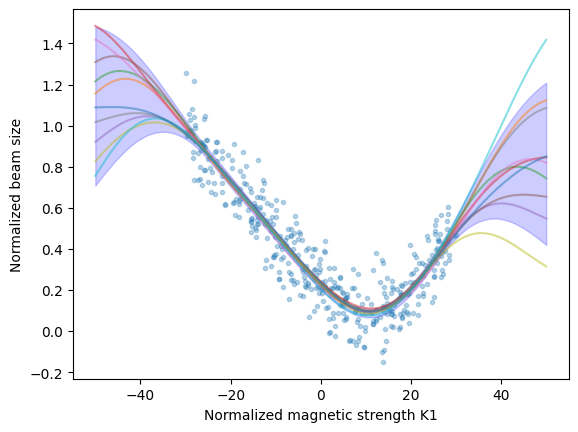

In [7]:
# Plot the original training data
plt.plot(train_x, train_y, '.', alpha=0.3)

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-50.0, 50.0, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=False)

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

> ### **Task:**
> Does the uncertainty behave as expected? In which way? Does the predicted uncertainty capture the aleatoric part or only the epistemic part? Copy the above code below, and change `observation_noise` from `False` to `True`. Does it now capture the aleatoric part or only the epistemic part?

> **Your answer here** (Does the uncertainty behave as expected? In which way? Does the predicted uncertainty capture the aleatoric part or only the epistemic part?)

In [8]:
# BEGIN SOLUTION
"""
The uncertainty behaves as expected, in that it is low in the area of input space where many training points
are available (between 0 and 1) and grows outside of this area. The typical distance over which the uncertainty
grows is consistent with the typical length scale of the function.
This does not capture the aleatoric part: in the area between -20 and 20, the uncertainty is much smaller than
the typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the *average*
beam size, i.e. with the random noise removed.
"""
# END SOLUTION

'\nThe uncertainty behaves as expected, in that it is low in the area of input space where many training points\nare available (between 0 and 1) and grows outside of this area. The typical distance over which the uncertainty\ngrows is consistent with the typical length scale of the function.\nThis does not capture the aleatoric part: in the area between -20 and 20, the uncertainty is much smaller than\nthe typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the *average*\nbeam size, i.e. with the random noise removed.\n'

Text(0, 0.5, 'Normalized beam size')

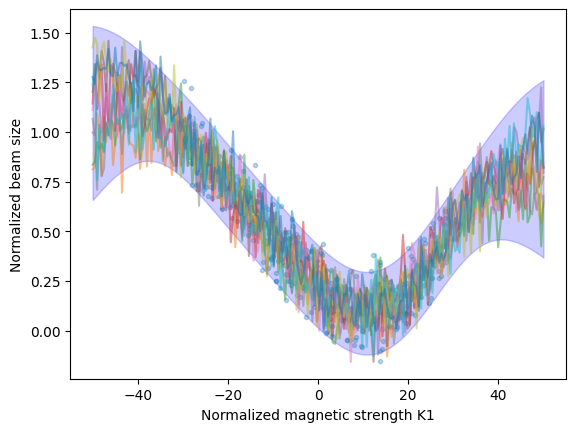

In [9]:
# Your code here: Copy the above code below, and change`observation_noise` from `False` to `True`.

# BEGIN SOLUTION

# Plot the original training data
plt.plot(train_x, train_y, '.', alpha=0.3)

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-50.0, 50.0, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=True)

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# END SOLUTION

> **Your answer here** (Does it now capture the aleatoric part or only the epistemic part?)

In [10]:
# BEGIN SOLUTION
"""
This now captures the aleatoric part: in the area between -20 and 20, the uncertainty is of similar amplitude as
the typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the beam size
with the random noise taken into account.
"""
# END SOLUTION

'\nThis now captures the aleatoric part: in the area between -20 and 20, the uncertainty is of similar amplitude as\nthe typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the beam size \nwith the random noise taken into account.\n'

# Ensemble of neural networks

We will now train an **ensemble** of neural networks on the same data.

> ### **Task:**
> Implement a neural network with 2 hidden layers of 10 neurons each.
> Train 10 randomly initialized models on the same data. Store the trained models in a list.

In [11]:
# normalize training data
normed_train_x = ((train_x - train_x.min()) / (train_x.max() - train_x.min())).float()
normed_train_y = ((train_y - train_y.min()) / (train_y.max() - train_y.min())).float()

In [12]:
class NNModel(nn.Module):
    """
    Define fully-connected neural network with 2 hidden layers
    """
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(), # First hidden layer: size 10
            nn.Linear(10, 10),
            nn.ReLU(), # Second hidden layer: size 10
            nn.Linear(10, 1),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [13]:
def generate_and_train_model( epochs=100, plot_loss=True ):
    """
    Train a neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    model = NNModel()

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = nn.MSELoss()(normed_train_y, output)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training Loss' )

    return model


100%|██████████| 100/100 [00:00<00:00, 280.31it/s]


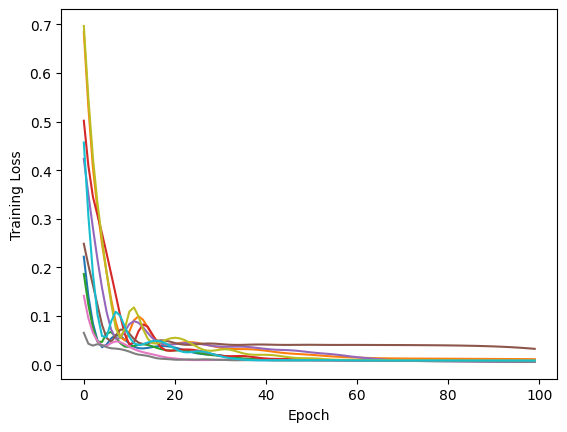

In [14]:
# Train 10 different neural network on the same data
ensemble_models = [ generate_and_train_model() for _ in range(10) ]

In [15]:
def plot_samples_with_mean_plusminus_std(x, y_samples, show_samples=True):
    """
    Helper function that plots samples, along with the mean +/- std

    x: numpy array of size (n,)
        points on the horizontal axis

    y_samples: list of numpy arrays of size (n,)
        the corresponding samples

    show_samples: bool
        whether to show the samples or only the mean and std
    """
    # Plot samples
    if show_samples:
        for i in range(len(y_samples)):
            plt.plot(x, y_samples[i], alpha=0.5)

    # Calculate mean and std
    y = np.array(y_samples)
    mean = np.mean(y,axis=0)
    std = np.std(y,axis=0)
    plt.plot( x, mean, 'b' )
    plt.fill_between( x, mean-std, mean+std, color='b', alpha=0.2)

> ### **Task:**
> Modify the code below to plot sample predictions from the ensemble of neural network, and to plot the mean and uncertainty. Since each neural network has been trained on the same dataset, why do they give different predictions? Does the resulting uncertainty capture the aleatoric part?

Text(0, 0.5, 'Normalized beam size')

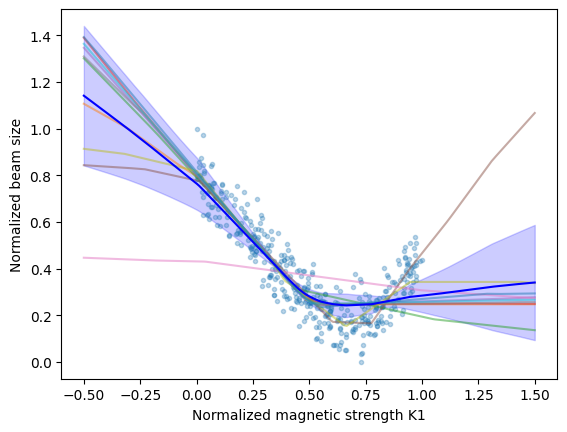

In [16]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []

for model in ensemble_models:
    # Your code here: capture the prediction of each neural network

    y_samples.append( model(x).detach().numpy().flatten() )

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

> **Your answer here:** (Since each neural network has been trained on the same dataset, why do they give different predictions? Does the resulting uncertainty capture the aleatoric part?)

In [17]:
# BEGIN SOLUTION
"""
The initial value of the weights of the neural networks are initialized randomly. Therefore they
are different for each of the neural networks in the ensemble. The initial weights influence the
subsequent training, and thus the trained neural networks in the ensemble do differ.

Ensembles of neural networks only predict the epistemic part of the uncertainty: we can see
that the uncertainty is much lower than the noise, in the area of the input space where
we have a lot of data.
"""
# END SOLUTION

'\nThe initial value of the weights of the neural networks are initialized randomly. Therefore they\nare different for each of the neural networks in the ensemble. The initial weights influence the\nsubsequent training, and thus the trained neural networks in the ensemble do differ.\n\nEnsembles of neural networks only predict the epistemic part of the uncertainty: we can see\nthat the uncertainty is much lower than the noise, in the area of the input space where\nwe have a lot of data.\n'

# Monte-Carlo Dropout

We now use a Monte-Carlo drop-out neural network to try to assess the uncertainty.

In [18]:
class MCDropoutModel(nn.Module):

    def __init__(self, p):
        """
        Initialize a Monte-Carlo drop-out neural network

        p: float
            Drop-out probability
        """
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 1),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [19]:
def generate_and_train_dropout_model( p=0.1, epochs=100, plot_loss=True ):
    """
    Train an MC drop-out neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    model = MCDropoutModel(p)

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = nn.MSELoss()(normed_train_y, output)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

100%|██████████| 200/200 [00:01<00:00, 108.33it/s]


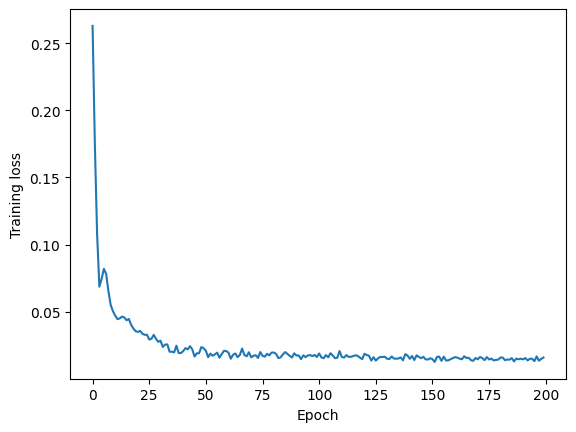

In [20]:
# Train the neural network in the presence of Drop-out
mcdropout_model = generate_and_train_dropout_model(epochs=200)

In [21]:
# Execute this cell several times.
# The result changes everytime, because different activation neurons are set to 0 (with probability p).
# This gives the uncertainty on the prediction.
mcdropout_model( torch.tensor([[0.3]]) )

tensor([[0.4972]], grad_fn=<AddmmBackward0>)

> ### **Task:**
> Generate 10 different sample predictions with the MC dropout model, and plot the samples with their corresponding uncertainty.

Text(0, 0.5, 'Normalized beam size')

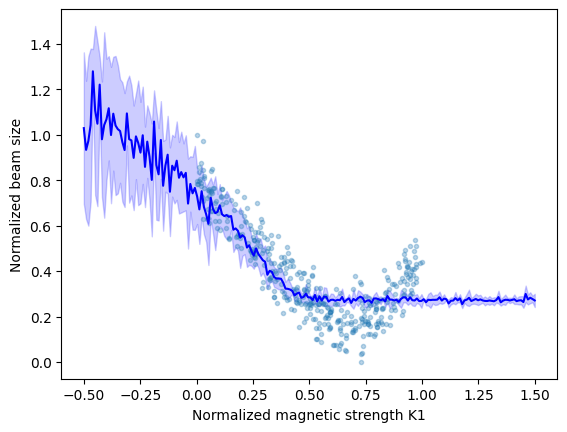

In [22]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

# BEGIN SOLUTION
y_samples = []
# Your code here: Collect 10 different sample predictions

for _ in range(10):
    y_samples.append( mcdropout_model(x).detach().numpy().flatten() )


plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=False)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# END SOLUTION

> ### **Task:**
> Execute the cell below, and plot samples with uncertainty bands for the model. What happens and why?

In [23]:
mcdropout_model.eval(); # Set in evaluation mode (this can be reverted by doing `mcdropout_model.train()`)

Text(0, 0.5, 'Normalized beam size')

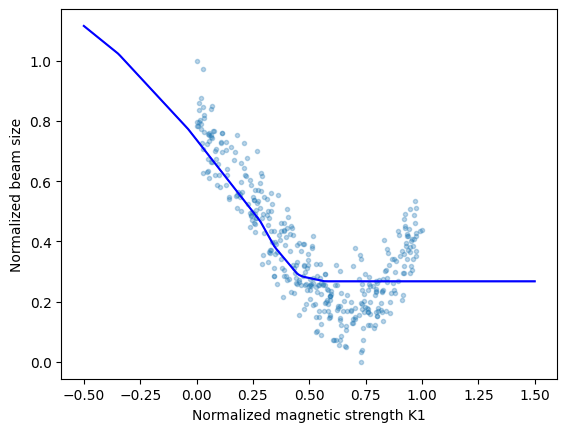

In [24]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

# BEGIN SOLUTION
y_samples = []
# Your code here: Collect 10 different sample predictions

for _ in range(10):
    y_samples.append( mcdropout_model(x).detach().numpy().flatten() )

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=False)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# END SOLUTION

> **Your answer here:** (What happens and why?)

In [25]:
# BEGIN SOLUTION
"""
In evaluation mode, the dropout layers do not randomly set *some* neurons' activate to 0, but it instead scales *all* neurons' activation by (1-p).
Therefore, evaluating the network several times does not produce different results.
We cannot evaluate the uncertainty by taking the standard deviations of several evaluations.
"""
# END SOLUTION

"\nIn evaluation mode, the dropout layers do not randomly set *some* neurons' activate to 0, but it instead scales *all* neurons' activation by (1-p).\nTherefore, evaluating the network several times does not produce different results.\nWe cannot evaluate the uncertainty by taking the standard deviations of several evaluations.\n"

# Quantile regression

We will now evaluate the uncertainty using quantile regression.

In quantile regression, we instantiate a regular neural network, but train it with specific loss function (see the slides) instead of the usual Mean Squared Error loss function.

> ### **Task:**
> Implement the quantile regression loss function in the cell below, and execute the following cells to fit quantile regression models to the data. Hint: use `torch.where`

In [26]:
def quantile_loss_function(y_true, y_pred, tau):
    """
    Return the loss function for quantile regression

    y_true: array of shape (n,1)
        data labels

    y_pred: array of shape (n,1)
        predictions of the machine learning model

    tau: float
        (number between 0 and 1)
    """
    # Your code below: modify the lines below to defined the quantile loss function
    # (The current code implements the MSE loss function instead.)

    error = y_true - y_pred
    #loss = torch.mean( error**2, axis=0 )

    # BEGIN SOLUTION
    loss = torch.mean( torch.where( error>0, tau*error, (1-tau)*(-error) ), axis=0 )
    # END SOLUTION

    return loss

In [27]:
def generate_and_train_quantile_model( tau, epochs=100, plot_loss=True ):
    """
    Train an quantile neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object

    quantile: float
        (number between 0 and 1)
    """
    model = NNModel()

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = quantile_loss_function(normed_train_y, output, tau=tau)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

100%|██████████| 200/200 [00:00<00:00, 483.87it/s]


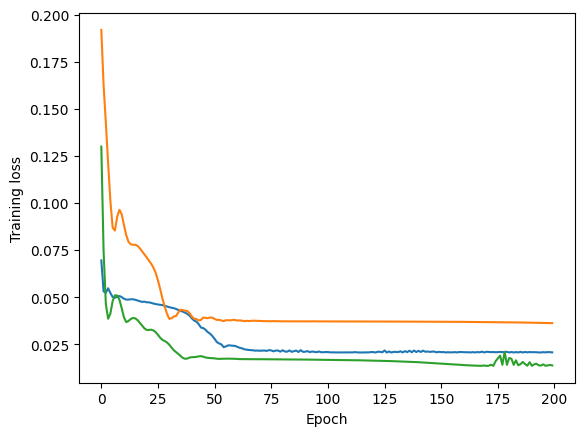

In [28]:
# Pick a few quantile values, and train a neural networks for each of them
tau_values = [0.2, 0.5, 0.9]
quantile_models = [ generate_and_train_quantile_model(tau, epochs=200) for tau in tau_values ]

Text(0, 0.5, 'Normalized beam size')

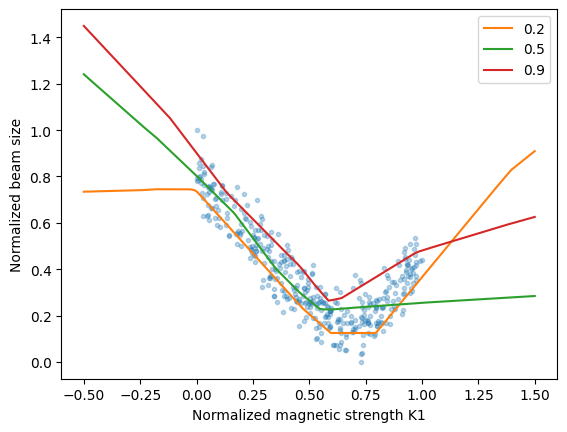

In [29]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

for model, tau in zip(quantile_models, tau_values):
    plt.plot( x, model(x).detach().numpy(), label=tau )
plt.legend(loc=0)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

> ### **Task:**
> Are the relative positions of the 0.2, 0.5 and 0.9 curves as expected? Does this capture the aleatoric part of the uncertainty?

In [30]:
# BEGIN SOLUTION
"""
The 0.9 is expected to be above the 0.5 curve, which is expected to be above 0.2 (by definition of the quantiles). This is satisfied in the area were the data is abundant.
Quantile regression does capture the aleatoric part (e.g. the distance between the 0.9 and 0.2 curve corresponds roughly to the amplitude of the noise.)
"""
# END SOLUTION

'\nThe 0.9 is expected to be above the 0.5 curve, which is expected to be above 0.2 (by definition of the quantiles). This is satisfied in the area were the data is abundant.\nQuantile regression does capture the aleatoric part (e.g. the distance between the 0.9 and 0.2 curve corresponds roughly to the amplitude of the noise.)\n'

# Bayesian neural networks

We will now use the `blitz` package to train bayesian neural networks. `blitz` combines with standard `pytorch` neural network models.

In [31]:
# Bayesian neural network
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [32]:
# Define a bayesian neural network with two hidden layers (with 10 neurons each)

# - We use `BayesianLinear` instead of `Linear`.
#     `BayesianLinear` holds `mu` and `rho` (for each neuron) as trainable parameter, instead of the weights directly.
#     Its output is random, as it draws random weights for each evaluation
# - `variational_estimator` enables additional methods for the class, including the ELBO loss function

@variational_estimator
class BayesianModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(1, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),
            BayesianLinear(10, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),
            BayesianLinear(10, 1, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [33]:
def generate_and_train_bayesian_model( epochs=1000, plot_loss=True ):
    """
    Train a Bayesian neural network, optionally plot the loss during training
    (to check convergence), and return the corresponding neural network object
    """
    model = BayesianModel()

    optimizer = optim.Adam(model.parameters(), lr=2e-2)

    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):

        loss = model.sample_elbo(inputs=normed_train_x,
                                 labels=normed_train_y,
                                 criterion=nn.MSELoss(),
                                 sample_nbr=2,
                                 complexity_cost_weight=1./normed_train_x.shape[0])
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )

    return model

100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s]


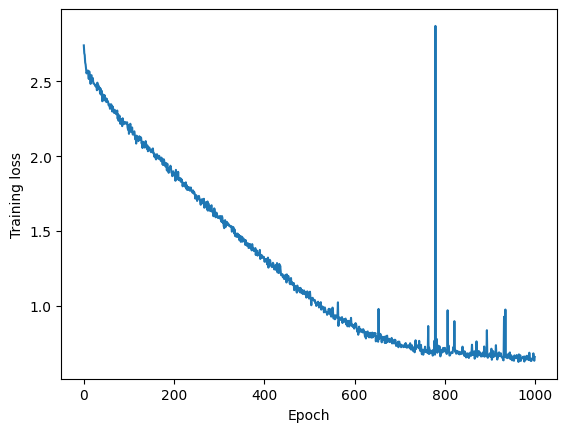

In [34]:
# Train the neural network
bayesian_model = generate_and_train_bayesian_model()

> ### **Task:**
> By modifying the code below, plot the uncertainty for the Bayesian neural network.

Text(0, 0.5, 'Normalized beam size')

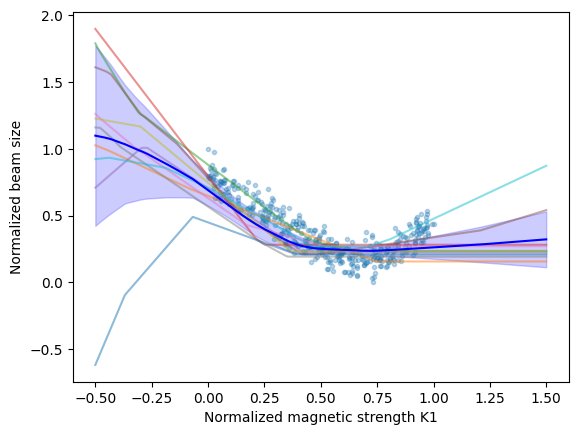

In [35]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
# Your code here: Collect 10 different sample predictions

for _ in range(10):
    y_samples.append( bayesian_model(x).detach().numpy().flatten() )

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# END SOLUTION